<a href="https://colab.research.google.com/github/mowas455/Toy-Train-PDM/blob/main/Toy_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toy Train PDM

### Feature explanation
* temperature - The temperature on board the Raspberry Pi
* pressure - The atmospheric pressure
* humidity - Humidity as measured by the sense hat
* gyro pitch - The pitch (up / down) angle of the Pi. Zero degrees indicates a horizontal Pi.
* gyro roll - The roll in degrees where zero indicates a horizontal Pi.
* gyro yaw - The yaw in degrees from 0 - 360, similar to a compass reading.

In [1]:
# !pip install pmdarima

## Libraries

In [2]:
### System Related
import sys
import warnings
import itertools
warnings.filterwarnings("ignore")

### math related 
from scipy .io import arff
import numpy as np
import pandas as pd
import seaborn as sns

### Statistical Analysis related
from sklearn import metrics
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

### stats model
import statsmodels.api as sm
from pmdarima import auto_arima
from pmdarima.model_selection import train_test_split 

## Functions

In [3]:
# Some predefines functions
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    '''
    Calculates statistical values whether the available data are stationary or not 
    
    Args:
        series (float64): Values of the column for which stationarity is to be checked, numpy array of floats 
        column_name (str): Name of the column for which stationarity is to be checked
    
    Returns:
        p-value that indicates whether the data are stationary or not
    ''' 
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

# Evaluation metrics
def mean_absolute_percentage_error(y_true, y_pred):
    '''
    Calculate the mean absolute percentage error as a metric for evaluation
    
    Args:
        y_true (float64): Y values for the dependent variable (test part), numpy array of floats 
        y_pred (float64): Predicted values for the dependent variable (test parrt), numpy array of floats
    
    Returns:
        Mean absolute percentage error 
    '''    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100



def timeseries_evaluation_metrics_func(y_true, y_pred, data= None):
    '''
    Calculate the following evaluation metrics:
        - MAE
        - RMSE
        - MAPE
        
    
    Args:
        y_true (float64): Y values for the dependent variable (test part), numpy array of floats 
        y_pred (float64): Predicted values for the dependen variable (test parrt), numpy array of floats
    
    Returns:
        MAE, RMSE, MAPE 
    '''    
    print(f'Evaluation metric results:{data} ')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    

In [4]:
# load the data
dataset = arff.loadarff(r'/content/sample_data/toy-train.arff')
data = pd.DataFrame(dataset[0])

In [5]:
# rough view about the data
print(data.head())
print(data.shape)

   temperature  pressure  humidity  gyro_pitch  gyro_roll  gyro_yaw
0        39.59   1017.30     22.54        2.83       1.26    210.09
1        39.81   1017.31     22.57        2.83       1.26    210.08
2        39.61   1017.31     22.93        2.83       1.26    210.12
3        39.74   1017.31     22.16        2.83       1.26    210.22
4        39.68   1017.32     22.69        2.84       1.26    210.27
(2335, 6)


# Exploratory Data Analysis (EDA)

#### Assumptions
The data is collected during the eight laps and sensor values are collected twice per second.

* From the toy data file, we observe there is 2335 data points.
* Approximately 2335 datapoints are collected in the 1167 seconds.
* The toy train taken to complete 1 lap = 145.875 seconds(2.4325 mins)
* 145.875 x 2 = 292(datapoints)  
* In 1 lap we are observing 292 data points, for 8 lap 292 x 8 = 2336(approx)

In [6]:
# # just for interpretation purpose
# ## Based on the assumption, we add new feature called time - that denotes time in seconds taken to collect the values(achieves consecutively) 
# seconds = []
# x = range(1, 1168)
# for n in x:
#   seconds.append(n)
#   seconds.append(n)
# seconds.append(1167)
# data['time'] = seconds

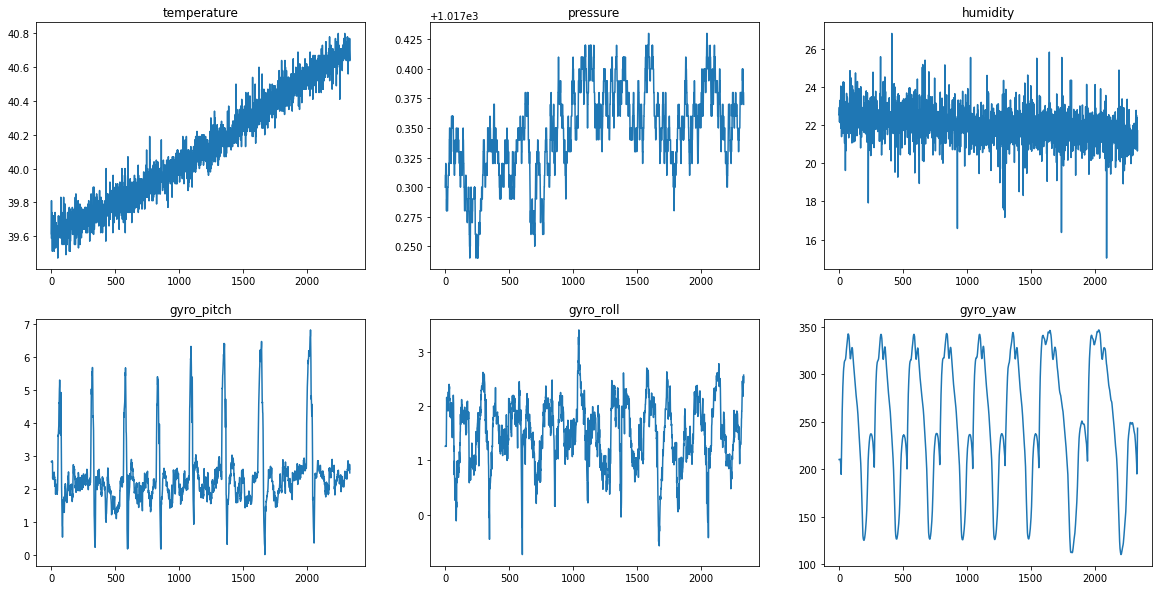

In [7]:
fig ,ax = plt.subplots(2,3,figsize=(20,10))
ax[0,0].plot(data['temperature'])
ax[0,0].set_title('temperature')
ax[0,1].plot(data['pressure'])
ax[0,1].set_title('pressure')
ax[0,2].plot(data['humidity'])
ax[0,2].set_title('humidity')
ax[1,0].plot(data['gyro_pitch'])
ax[1,0].set_title('gyro_pitch')
ax[1,1].plot(data['gyro_roll'])
ax[1,1].set_title('gyro_roll')
ax[1,2].plot(data['gyro_yaw'])
ax[1,2].set_title('gyro_yaw')
plt.show()

Since the data points or observations recorded at regular time intervals and also the data is having the temporal dependancy.

**Check for correlation between the variables:**
I want to know whether there is relationship betwween the other variables and gyro_yaw.Quantifying a relationship between two variables using the correlation coefficient only tells half the story, because it measures the strength of a relationship in samples only.

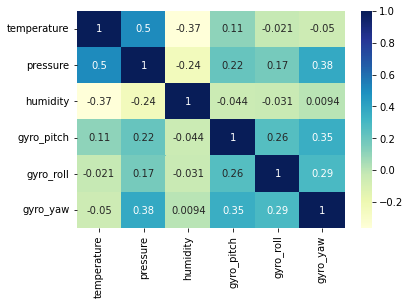

In [8]:
# plotting correlation heatmap
dataplot = sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)
  
# displaying heatmap
plt.show()

**Observation**:
From result of exploratory analysis, the sinusoidal pattern of the gyro_yaw is repeating but the space or gap between the curve is increasing for every lap. I approach this problem by using different methods,
1. Univariate Time Series forecasting (Classical statistical approach) - Baseline Model
2. Linear regression/XGBoost method (Pure Machine Learning approaches)
3. Neural network (Deep learning algorithm) 

* From the correlattion plot, pressure, gyro_pitch and gyro_roll is having a strong correlation with the gyro_yaw and the temperature and humidity is not correlated with gyro_yaw.
 

# Time Series Forecasting with SARIMA (Base line model)

In [9]:
# check the staionarity of data by using ADF test
Augmented_Dickey_Fuller_Test_func(data['gyro_yaw'],'gyro_yaw')

Results of Dickey-Fuller Test for column: gyro_yaw
Test Statistic                   -4.774630
p-value                           0.000061
No Lags Used                      3.000000
Number of Observations Used    2331.000000
Critical Value (1%)              -3.433158
Critical Value (5%)              -2.862781
Critical Value (10%)             -2.567430
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


In [10]:
# Split the data for training and test
X= data["gyro_yaw"]
trainX, testX = train_test_split(X,test_size = 0.3)
print('train size :',trainX.shape)
print('test size :',testX.shape)

train size : (1634,)
test size : (701,)


 Fitting SARIMA for Seasonal value m = 1
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=6485.372, Time=2.75 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=18353.058, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.49 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=22834.127, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=4830.664, Time=1.40 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=4829.125, Time=0.89 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=4830.718, Time=1.27 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=4829.703, Time=3.71 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.25 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 12.772 seconds
Model summary for  m = 1
----------------------------------------------------------------------------------------------------
Evaluation metric results:test 
MAE is : 53.07733544362625
RMSE i

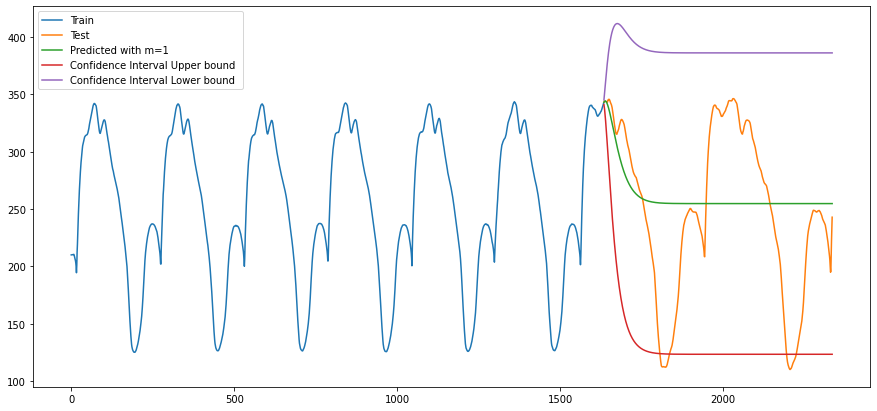

----------------------------------------------------------------------------------------------------
 Fitting SARIMA for Seasonal value m = 3
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[3] intercept   : AIC=5615.411, Time=7.43 sec
 ARIMA(0,0,0)(0,0,0)[3] intercept   : AIC=18353.058, Time=0.12 sec
 ARIMA(1,0,0)(1,0,0)[3] intercept   : AIC=inf, Time=3.82 sec
 ARIMA(0,0,1)(0,0,1)[3] intercept   : AIC=14221.579, Time=4.24 sec
 ARIMA(0,0,0)(0,0,0)[3]             : AIC=22834.127, Time=0.07 sec
 ARIMA(1,0,1)(0,0,1)[3] intercept   : AIC=6074.365, Time=5.08 sec
 ARIMA(1,0,1)(1,0,0)[3] intercept   : AIC=5651.238, Time=5.76 sec
 ARIMA(1,0,1)(2,0,1)[3] intercept   : AIC=inf, Time=11.55 sec
 ARIMA(1,0,1)(1,0,2)[3] intercept   : AIC=5606.473, Time=5.04 sec
 ARIMA(1,0,1)(0,0,2)[3] intercept   : AIC=5801.398, Time=3.69 sec
 ARIMA(1,0,1)(2,0,2)[3] intercept   : AIC=inf, Time=4.89 sec
 ARIMA(1,0,1)(1,0,3)[3] intercept   : AIC=5742.653, Time=7.38 sec
 ARIMA(1,0,1)(0,0,3)[3] intercept 

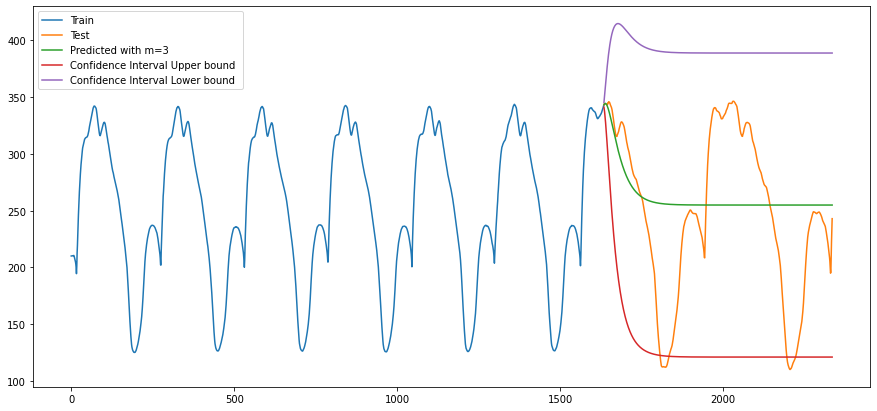

----------------------------------------------------------------------------------------------------


In [11]:
df_results_SARIMA = pd.DataFrame()

## where m is the period of repeating seasonal pattern
## so we used different m values
for m in  [1, 3]:
    print("="*100)
    print(f' Fitting SARIMA for Seasonal value m = {str(m)}')
    # Seasonal- ARIMA model
    stepwise_model = auto_arima(trainX, start_p=1, start_q=1,
                                max_p=7, max_q=7, seasonal=True, start_P=1, 
                                start_Q=1, max_P=7, max_D=7, max_Q=7, m=m,
                                d=None, D=None, trace=True, error_action='ignore', 
                                suppress_warnings=True, stepwise=True)

    print(f'Model summary for  m = {str(m)}')
    print("-"*100)
    stepwise_model.summary()
    
    # forecast & confidence interval
    forecast ,conf_int= stepwise_model.predict(n_periods=len(testX),return_conf_int=True)
    df_conf = pd.DataFrame(conf_int,columns= ['Upper_bound','Lower_bound'])
    df_conf["new_index"] = range(len(trainX), len(X))
    df_conf = df_conf.set_index("new_index")
    forecast = pd.DataFrame(forecast, columns=['close_pred'])
    forecast["new_index"] = range(len(trainX), len(X))
    forecast = forecast.set_index("new_index")

    timeseries_evaluation_metrics_func(testX, forecast,data = 'test')
    
    
    # Storage of m value for each model in a separate table 
    rmse = np.sqrt(metrics.mean_squared_error(testX, forecast))    
    df1 = {'m':m, 'RMSE': rmse}
    df_results_SARIMA = df_results_SARIMA.append(df1, ignore_index=True)

    # plot the orginal vs predicted 
    plt.rcParams["figure.figsize"] = [15, 7]
    plt.plot(trainX, label='Train ')
    plt.plot(testX, label='Test ')
    plt.plot(forecast, label=f'Predicted with m={str(m)} ')
    plt.plot(df_conf['Upper_bound'], label='Confidence Interval Upper bound ')
    plt.plot(df_conf['Lower_bound'], label='Confidence Interval Lower bound ')
    plt.legend(loc='best')
    plt.show()
    
    print("-"*100)


# 1. Linear regression method using polynomial features
From the plot, the data points clearly show that it will not fit the linear regressioon. so, I thought it might be ideal for the polynomial regression(due to non-linear curve).
Polynomial Regression is a form of linear regression in which the relationship between the independent variable x and dependent variable y is modeled as an nth degree polynomial. Polynomial regression fits a nonlinear relationship between the value of x and the corresponding conditional mean of y.



Initailly I used all the features to ploynomial regression model. From the results, I observed that the variance is higher between the training and test data. To reduce the variance, I dropped some feature and see how the model is performing. By dropping the pressure and humdity, the model is performing well and variance between the training and test data is also less.

In [12]:
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from numpy import absolute

In [13]:
# data with all features
features0 =  ['temperature','pressure','humidity','gyro_pitch','gyro_roll']
x0 = data[features0]

# data with limited features
features =  ['pressure','gyro_pitch','gyro_roll']
x = data[features]

# target
y = data['gyro_yaw']

trainx, testx, trainy, testy = train_test_split(x0, y, test_size = 0.3)
Xtrain, Xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.3)

In [14]:

def polynomial_regression(x, y, degrees,testsize):
  '''
  Use the linear regression with the help of ploynomial features

  Args:
   x  : pandas.DataFrame
   y  : pandas.DataFrame
   degrees         : list

  Return:
   train prediction
   test prediction 
  '''
  # split the train and test
  trainx, testx, trainy, testy = train_test_split(x, y, test_size = testsize)

  # initialise y_train_pred and y_test_pred matrices to store the train and test predictions
  # each row is a data point, each column a prediction using a polynomial of some degree
  y_train_pred = np.zeros((len(trainx), len(degrees)))
  y_test_pred = np.zeros((len(testx), len(degrees)))
  
  for i, degree in enumerate(degrees):
     # make pipeline: create features, then feed them to linear_reg model
     model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
     model.fit(trainx, trainy)
    
     # predict on test and train data
     # store the predictions of each degree in the corresponding column
     y_train_pred[:, i] = model.predict(trainx)
     y_test_pred[:, i] = model.predict(testx)
  
  return y_train_pred,y_test_pred

### Perfomance of model with all features

In [15]:
degrees = [1,2,3,4]
y_train_pred0,y_test_pred0 = polynomial_regression(x0,y,degrees,0.3)

for n in range(0,3):
  print(f'Polynomial regression of degree:',degrees[n])
  timeseries_evaluation_metrics_func(trainy,y_train_pred0[:,n],data='train')
  timeseries_evaluation_metrics_func(testy,y_test_pred0[:,n],data = 'test')
  print('\n')

Polynomial regression of degree: 1
Evaluation metric results:train 
MAE is : 42.4904139634596
RMSE is : 53.60249323264321
MAPE is : 20.37246681949899
Evaluation metric results:test 
MAE is : 63.87009365745017
RMSE is : 75.26783687189977
MAPE is : 25.303526813546966


Polynomial regression of degree: 2
Evaluation metric results:train 
MAE is : 39.2647688472519
RMSE is : 49.36613035555788
MAPE is : 18.36166712009505
Evaluation metric results:test 
MAE is : 59.091194204964424
RMSE is : 76.45243601415449
MAPE is : 25.869523467501427


Polynomial regression of degree: 3
Evaluation metric results:train 
MAE is : 35.50705190240681
RMSE is : 44.90164605264355
MAPE is : 16.64370122506845
Evaluation metric results:test 
MAE is : 60.025497321592766
RMSE is : 76.08310486299581
MAPE is : 25.77211323886524




### Perfomance of model with limited features

In [16]:
degrees = [1,2,3,4]
y_train_pred,y_test_pred = polynomial_regression(x,y,degrees,0.3)

In [17]:
for n in range(0,3):
  print(f'Polynomial regression of degree:',degrees[n])
  timeseries_evaluation_metrics_func(trainy,y_train_pred[:,n],data='train')
  timeseries_evaluation_metrics_func(testy,y_test_pred[:,n],data = 'test')
  print('\n')

Polynomial regression of degree: 1
Evaluation metric results:train 
MAE is : 44.86161214939594
RMSE is : 57.13025524889009
MAPE is : 21.433436561252588
Evaluation metric results:test 
MAE is : 50.16349354013303
RMSE is : 64.27303765973761
MAPE is : 26.970349173821003


Polynomial regression of degree: 2
Evaluation metric results:train 
MAE is : 44.38113384130097
RMSE is : 55.1943283025258
MAPE is : 20.88354754200686
Evaluation metric results:test 
MAE is : 45.92670608209645
RMSE is : 59.02465109611869
MAPE is : 24.988727631178577


Polynomial regression of degree: 3
Evaluation metric results:train 
MAE is : 39.42911893109213
RMSE is : 50.815691985361504
MAPE is : 18.56683719413241
Evaluation metric results:test 
MAE is : 43.5614238682419
RMSE is : 57.438471010069144
MAPE is : 23.385074606183455




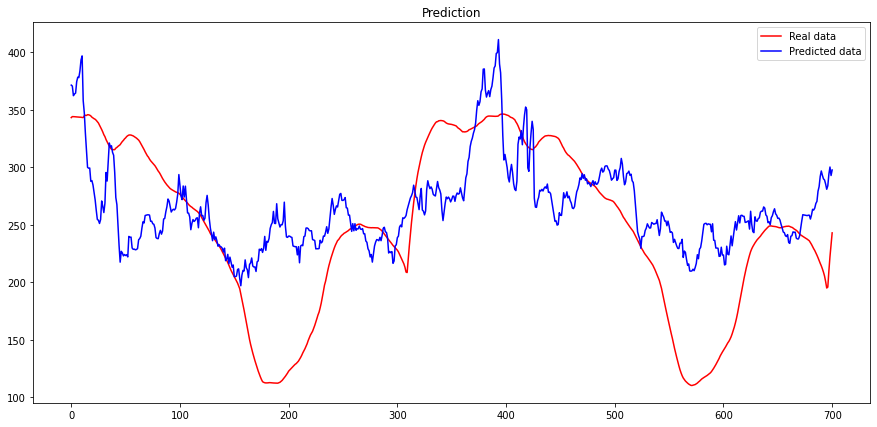

In [18]:
# plot show prediction of regression model with limited features
plt.plot(testy.values, color = 'red', label = 'Real data')
plt.plot(y_test_pred[:,1], color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

# 2. XGBoost Regressor

In [19]:
import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBRegressor, plot_tree
from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings("ignore")

**Grid search for XGBoost**


Parameter estimation.
* n_estimators: specifies the number of decision trees to be boosted. If 
n_estimator = 1, it means only 1 tree is generated, thus no boosting is at work. The default value is 100. So I played around with [10,20,30] with minimal decision tree, because that gives the optimal performance.
* colsample_bytree: that denotes about fractions of columns selected for each tree.
* max_depth: it limits how deep each tree can grow. The default value is 6 but to avoid overfiting problem, I gave a lower values.
* reg_alpha:it is the L1 regularization parameter, increasing its value makes the model more conservative. Default is 0.

* reg_lambda: L2 regularization parameter, increasing its value also makes the model conservative. Default is 1
* subsample:it represents the subsample ratio of the training sample. A subsample = 0.7,0.8,0.9 means that 70,80,90 precent of training data is used prior to growing a tree. The value can be any fraction but the default value is 1.

With the help of Grid Search CV, we validate the model with different range of parameters.From the result of grid seach, I found the best hyperparameters for the XGBoost model

In [20]:
def xgboost_gridsearch(trainx, trainy, parameters, fit_params, cv):
  '''
  Implement the gridsearch for hyperparameters in XGBoost

  Args:
    trainx(float64) : pandas.DataFrame
    trainy(float64) : pandas.DataFrame
    parameters      : list with a range of model hyperparameters
    fit_params      : model fit args
    cv              : cross validation split

  Return:
    print - best parameters and best model estimator

  '''
  # model
  xgb_grid = XGBRegressor(objective= 'reg:linear')
  
  # grid search implementation
  cv = cv
  grid_search = GridSearchCV(
    estimator=xgb_grid,
    param_grid=parameters,
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1,
    cv = TimeSeriesSplit(n_splits=cv).get_n_splits([trainx, trainy]),
    verbose=1)
  
  # fit
  xgb_grid_model = grid_search.fit(trainx, trainy, **fit_params) 

  print('Best Parameter:')
  print(xgb_grid_model.best_params_) 
  print()
  print('------------------------------------------------------------------')
  print()
  print(xgb_grid_model.best_estimator_)

  return xgb_grid_model

In [21]:
parameters = {
    'n_estimators': [10,20,30],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [2,3,5],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
    'subsample': [0.7, 0.8, 0.9]}

fit_params={"early_stopping_rounds":10, 
            "eval_metric" : "mae", 
            "eval_set" : [[testx, testy]]}

In [22]:
xgb_grid_model = xgboost_gridsearch(trainx,trainy,parameters,fit_params,5)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
[14:24:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:225.3
Will train until validation_0-mae hasn't improved in 10 rounds.
[1]	validation_0-mae:203.876
[2]	validation_0-mae:185.267
[3]	validation_0-mae:169.257
[4]	validation_0-mae:152.683
[5]	validation_0-mae:138.39
[6]	validation_0-mae:125.558
[7]	validation_0-mae:114.895
[8]	validation_0-mae:105.856
[9]	validation_0-mae:98.2918
[10]	validation_0-mae:90.8137
[11]	validation_0-mae:84.8052
[12]	validation_0-mae:79.3841
[13]	validation_0-mae:75.4195
[14]	validation_0-mae:71.5741
[15]	validation_0-mae:68.1872
[16]	validation_0-mae:65.2281
[17]	validation_0-mae:62.7199
[18]	validation_0-mae:60.2066
[19]	validation_0-mae:58.3469
[20]	validation_0-mae:56.3378
[21]	validation_0-mae:54.7606
[22]	validation_0-mae:53.1214
[23]	validation_0-mae:52.2019
[24]	validation_0-mae:51.008
[25]	vali

### Prdection of XGBoost with all features.

In [23]:
# Fit the xgboost model with best parameters.
xgb0 = XGBRegressor(colsample_bytree=0.8, max_depth=5, n_estimators=30, reg_alpha=1.2,
             reg_lambda=1.2, subsample=0.8,objective ='reg:squarederror')
xgb0.fit(trainx, trainy)

XGBRegressor(colsample_bytree=0.8, max_depth=5, n_estimators=30,
             objective='reg:squarederror', reg_alpha=1.2, reg_lambda=1.2,
             subsample=0.8)

Evaluation metric results:test 
MAE is : 47.4362803390873
RMSE is : 58.880989562539305
MAPE is : 21.521156612283196


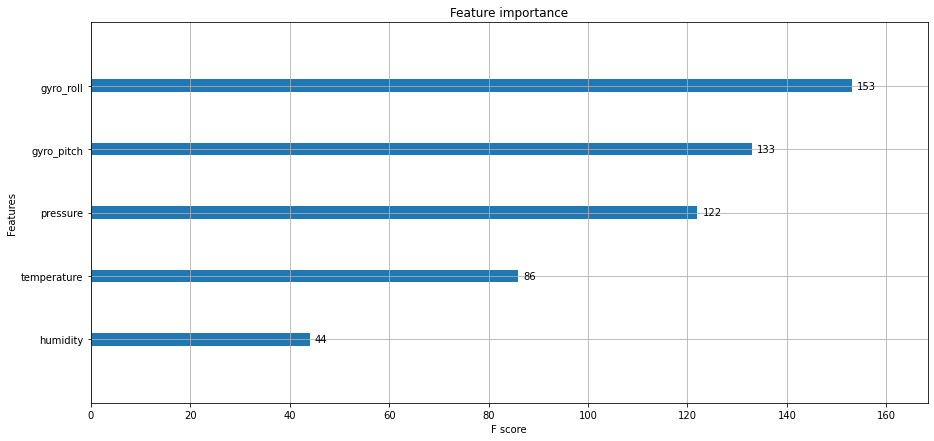

In [24]:
# predictions
preds_train0 = xgb0.predict(trainx)
preds_test0 = xgb0.predict(testx)

# performance evaluation
timeseries_evaluation_metrics_func(testy,preds_test0,data = 'test')

# plot feature importance
plot_importance(xgb0)
plt.show()

### Prediction of XGBoost with important features

Evaluation metric results:test 
MAE is : 43.72584879876543
RMSE is : 56.925703080813435
MAPE is : 22.705350300930764


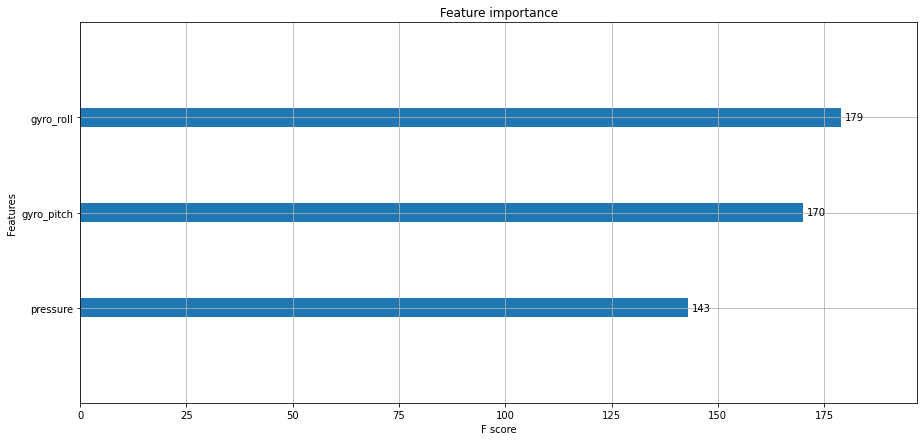

In [25]:
# Fit the xgboost model with best parameters.
xgb = XGBRegressor(colsample_bytree=0.8, max_depth=5, n_estimators=30, reg_alpha=1.2,
             reg_lambda=1.2, subsample=0.8,objective ='reg:squarederror')
xgb.fit(Xtrain, ytrain)

# predictions
preds_train = xgb.predict(Xtrain)
preds_test = xgb.predict(Xtest)

# performance evaluation
timeseries_evaluation_metrics_func(ytest,preds_test,data = 'test')

# plot feature importance
plot_importance(xgb)
plt.show()

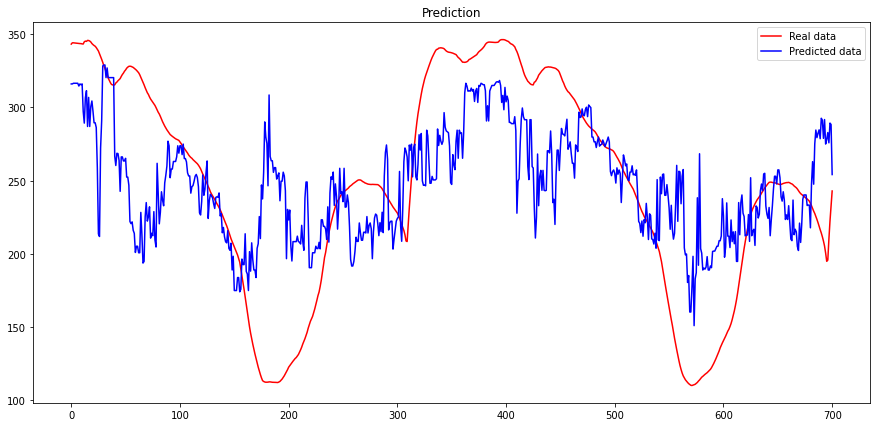

In [26]:
plt.plot(testy.values, color = 'red', label = 'Real data')
plt.plot(preds_test, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

In [27]:
# fig, ax = plt.subplots(figsize=(30, 30))
# plot_tree(xgb_grid_model.best_estimator_, num_trees=1, ax=ax)
# plt.show()

# Neural network

Activation: Neural network need nonlinearity to address nonlinear problems, and usually the only place where that nonlinearity can be injected is in the activation function. Yet ReLU, while strictly mathematically is not a linear function, is comprised of two linear functions (piecewise linear).

From the above the feature importance plot, I understand that pressure, gyro_pitch and gyro_roll have highest importance while predicting the gyro_yaw. So, I used only the important attributes or features to predict the gyro_yaw.

In [28]:
from keras.layers import Dense, Activation
from keras.models import Sequential
from keras.layers import LeakyReLU

In [29]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(Xtrain)
X_test = sc.transform(Xtest)

In [30]:
def nn_model(X, y, n,input_shape):
  '''
  Use neural network with non-linear activation function
  Args:
   X : trainX
   y : trainY
   n : epoch
   input_shape : data size(input dimension)
   
  Return:
   model
  '''
  # Initialising the ANN
  model = Sequential()

  # Adding the input layer and the first hidden layer
  model.add(Dense(32, activation = 'relu', input_dim = input_shape))

  # Adding the second hidden layer
  model.add(Dense(units = 32, activation = 'relu'))

  # Adding the third hidden layer
  model.add(Dense(units = 32, activation = 'relu'))

  # Adding the output layer
  model.add(Dense(units = 1))

  model.compile(optimizer = 'adam',loss = 'mean_absolute_error')

  model.fit(X, y, batch_size = 10, epochs = n,validation_split=0.2)
  
  return model

In [31]:
nn = nn_model(X_train,trainy,50,3)

Epoch 1/50
131/131 [==============================] - 1s 4ms/step - loss: 236.5350 - val_loss: 193.3674
Epoch 2/50
131/131 [==============================] - 0s 2ms/step - loss: 83.5894 - val_loss: 44.7519
Epoch 3/50
131/131 [==============================] - 0s 2ms/step - loss: 53.6491 - val_loss: 42.4392
Epoch 4/50
131/131 [==============================] - 0s 3ms/step - loss: 50.3629 - val_loss: 43.0579
Epoch 5/50
131/131 [==============================] - 0s 2ms/step - loss: 48.1631 - val_loss: 39.2152
Epoch 6/50
131/131 [==============================] - 0s 2ms/step - loss: 46.9580 - val_loss: 40.3340
Epoch 7/50
131/131 [==============================] - 0s 2ms/step - loss: 45.9650 - val_loss: 38.6773
Epoch 8/50
131/131 [==============================] - 0s 2ms/step - loss: 45.5011 - val_loss: 40.8983
Epoch 9/50
131/131 [==============================] - 0s 2ms/step - loss: 44.9325 - val_loss: 38.3187
Epoch 10/50
131/131 [==============================] - 0s 2ms/step - loss: 44.64

In [32]:
ytpred = nn.predict(X_train)
yy_pred = nn.predict(X_test)

timeseries_evaluation_metrics_func(testy,yy_pred, data='test')

Evaluation metric results:test 
MAE is : 44.11680184139845
RMSE is : 55.07820414084686
MAPE is : 36.019870861199706


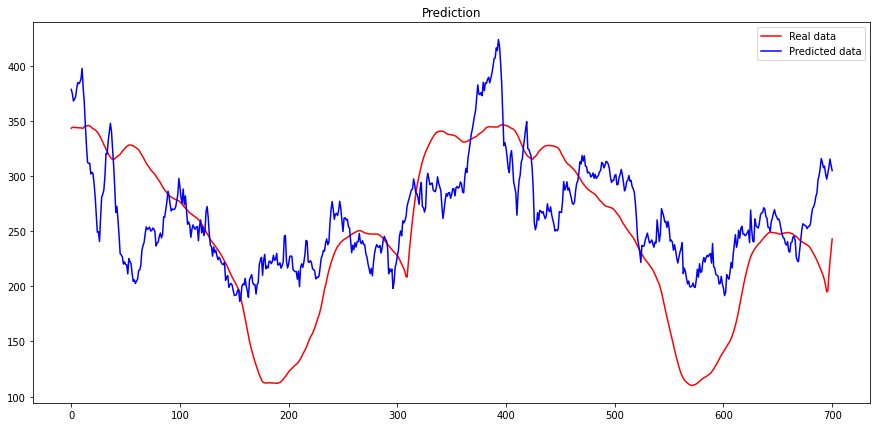

In [33]:
plt.plot(testy.values, color = 'red', label = 'Real data')
plt.plot(yy_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

# To predict the gyro_yaw ten step into the future.

The experiment was done on different methods to achieve a good performance. 
I presented the performance overview of methodolgies.Based on the performance evaluation, I consider the XGBoost is the best model to predict the gyro_yaw ten steps into the future.

* However, I am using all the methods to predict the ten steps into the future.
Exspecially, I am using only the pressure, gyro_pitch and gyro_roll.



### Seasonal ARIMA with best parameters

In [34]:
X = data['gyro_yaw'][:-10]
Y = data['gyro_yaw'][-10:]

# define model
sarima = sm.tsa.statespace.SARIMAX(trainX,
                                order=(2,0,0),
                                seasonal_order=(0,0,2,3),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
# fit model
sarima_fit = sarima.fit(disp=False)

# predict the train and test
train_pred = sarima_fit.predict()
test_pred = sarima_fit.forecast(10)

In [35]:
timeseries_evaluation_metrics_func(Y,test_pred,data = 'test')

Evaluation metric results:test 
MAE is : 133.38730541307484
RMSE is : 134.157161712
MAPE is : 63.509710990031145


### Linear regression with polynomial feature

In [36]:
XX = data[features]
yy = data['gyro_yaw']

In [37]:
trainXX, testXX, trainYY, testYY = train_test_split(XX, yy, test_size = 0.0041)
print(testYY.shape)

(10,)


In [38]:
trainpred,testpred = polynomial_regression(XX,yy,[1,2],0.0041)
# evaluation
timeseries_evaluation_metrics_func(testYY,testpred[:,0],data = 'test degree = 1 ')
timeseries_evaluation_metrics_func(testYY,testpred[:,1],data = 'test degree = 2')

Evaluation metric results:test degree = 1  
MAE is : 82.5605401345263
RMSE is : 84.07180378678788
MAPE is : 39.50417321877418
Evaluation metric results:test degree = 2 
MAE is : 80.03915797805784
RMSE is : 80.8150085870577
MAPE is : 38.16439178524422


### XGBoost with best parameters

In [39]:
bestxgb = XGBRegressor(colsample_bytree=0.7, max_depth=5, n_estimators=30, reg_alpha=1.2,
             reg_lambda=1.2, subsample=0.7,objective ='reg:squarederror')
bestxgb.fit(trainXX, trainYY)

XGBRegressor(colsample_bytree=0.7, max_depth=5, n_estimators=30,
             objective='reg:squarederror', reg_alpha=1.2, reg_lambda=1.2,
             subsample=0.7)

In [40]:
# predictions
predstrain = bestxgb.predict(trainXX)
predstest = bestxgb.predict(testXX)
timeseries_evaluation_metrics_func(testYY,predstest,data = 'test')

Evaluation metric results:test 
MAE is : 65.76107751464842
RMSE is : 69.37762822717389
MAPE is : 31.690995306747848


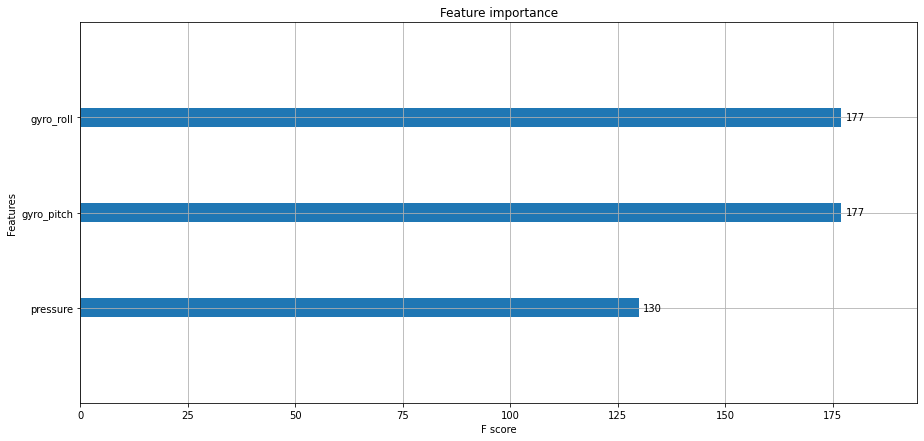

In [41]:
# plot feature importance
plot_importance(bestxgb)
plt.show()

### Neural network

In [42]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(trainXX)
X_test = sc.transform(testXX)

nn = nn_model(X_train,trainYY,50,3)
predty = nn.predict(X_train)
predyy = nn.predict(X_test)

timeseries_evaluation_metrics_func(testYY,predyy, data='test')


Epoch 1/50
186/186 [==============================] - 1s 3ms/step - loss: 197.4508 - val_loss: 60.7388
Epoch 2/50
186/186 [==============================] - 0s 2ms/step - loss: 55.7492 - val_loss: 51.0144
Epoch 3/50
186/186 [==============================] - 0s 2ms/step - loss: 50.6132 - val_loss: 45.1551
Epoch 4/50
186/186 [==============================] - 0s 2ms/step - loss: 47.7736 - val_loss: 42.7182
Epoch 5/50
186/186 [==============================] - 0s 2ms/step - loss: 45.9083 - val_loss: 41.4903
Epoch 6/50
186/186 [==============================] - 0s 2ms/step - loss: 44.9194 - val_loss: 40.4928
Epoch 7/50
186/186 [==============================] - 0s 2ms/step - loss: 43.9562 - val_loss: 39.9049
Epoch 8/50
186/186 [==============================] - 0s 3ms/step - loss: 43.5067 - val_loss: 38.5235
Epoch 9/50
186/186 [==============================] - 0s 2ms/step - loss: 42.8727 - val_loss: 40.1987
Epoch 10/50
186/186 [==============================] - 0s 2ms/step - loss: 42.478

# Conclusion.
Based on the experiment, it is evident that the XGBoost is the best model for this problem to predict the gyro_yaw. The evaluation meteric that I used to evaluate the performance of model are root means square error (RMSE) is a measure used to determine whether a model is accurate and how much error it produces. The Mean Absolute Error (MAE) is a superior measure when evaluating a model and the mean absolute precentage error is helpful to know about the percentage of errorr rate oaccurs for the model. In the overall experiment, I used the pressure, gyro_pitch and gyro_roll to predict the gyro_yaw that is clearly determined by the feature importance plot.